# Import libraries

In [1]:
# importing libraries
import os, sys 
sys.path.append(os.path.dirname(os.path.realpath('/Users/paulosgidyelew/Desktop/cassava-classification-capstone/src')))
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, MaxPooling2D,InputLayer, Dense, Dropout, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import itertools, cv2
import seaborn as sns
import glob
from PIL import Image
from collections import Counter

# user defined module
from src import f2,conf_matrix

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

# creat a variable for file path
#train_file_path = '/content/drive/MyDrive/train/' 

/Users/paulosgidyelew/Desktop/Capstone_Project/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#download kaggle api (kaggle.json) and import it here
from google.colab import files
files.upload()

In [ ]:

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-disease -f train.zip
!kaggle competitions download -c cassava-disease -f test.zip

 98% 762M/777M [00:05<00:00, 137MB/s]
100% 777M/777M [00:05<00:00, 147MB/s]
 97% 497M/515M [00:04<00:00, 133MB/s]
100% 515M/515M [00:04<00:00, 129MB/s]


In [ ]:
!unzip train.zip > /dev/null
!unzip test.zip > /dev/null

In [2]:
#train_file_path ='/content/train/'

train_file_path = '../data/cassava-disease/train/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Let us create a dictionary that contains the diseases or healthy as keys and a list with all the filepaths of the images in a list as their values

In [3]:
# create a dictionary for the image files

images_dict = {
                'cbb': [path for path in glob.glob(train_file_path+'cbb/*.jpg')],
                'cbsd': [path for path in glob.glob(train_file_path+'cbsd/*.jpg')],
                'cgm': [path for path in glob.glob(train_file_path+'cgm/*.jpg')],
                'cmd': [path for path in glob.glob(train_file_path+'cmd/*.jpg')],
                'healthy': [path for path in glob.glob(train_file_path+'healthy/*.jpg')]
                }

In [4]:
# create a dictionary for the labels

labels_dict = {
                'cbb': 0,
                'cbsd': 1,
                'cgm': 2,
                'cmd': 3,
                'healthy': 4
                }

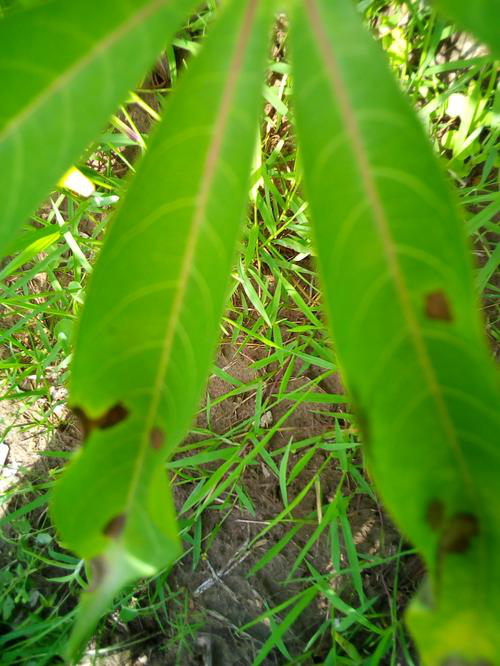

In [25]:
# check if data is loaded 

#Image.open(''.join(images_dict['cbb'][0]))
Image.open((images_dict['cbb'][0]))

In [6]:
# transform image into 3D tensor
# resize it to 224x224x3 vector

X, y = [], []

for labels, images in images_dict.items():
    for image in images:
        img = cv2.imread(''.join(image))
        resized_img = cv2.resize(img, dsize=(224,224))
        X.append(resized_img)
        y.append(labels_dict[labels])

In [7]:
# create an numpy_array
X = np.array(X)
y = np.array(y)

# Resampling of imbalanced dataset

### Over-sampling

In [19]:
#pip install imblearn

In [8]:
# Over-sampling

from imblearn.over_sampling import SMOTE

print(f'Original dataset shape: {Counter(y)}')
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.reshape(X.shape[0], -1), y.ravel())
X_res = X_res.reshape(-1,224,224,3)
print(f'Resampled dataset shape: {Counter(y_res)}')

Original dataset shape: Counter({3: 2658, 1: 1443, 2: 773, 0: 466, 4: 316})
Resampled dataset shape: Counter({0: 2658, 1: 2658, 2: 2658, 3: 2658, 4: 2658})


### Lets look the followig to understand what is going on with the reshaping:
<mark>X.reshape(X.shape[0], -1)</mark> means besically <mark>`X.reshape(5656, 224x224x3) = X.reshape(5656, 150528) = X.reshape(-1, 224x224x3)`</mark> and the data type is `uint8`, we will convert it into `float32` in the preprocessing section.


In [9]:
# shape of X before reshaping and resampling

X.shape

(5656, 224, 224, 3)

In [10]:
X.reshape(-1,224*224*3).shape

(5656, 150528)

In [11]:
X.reshape(X.shape[0], -1)

array([[  2, 119,  44, ...,   0, 136,  78],
       [ 26,  57,  52, ...,  37,  63,  69],
       [128, 131,  89, ...,  72, 129,  78],
       ...,
       [180, 229, 214, ..., 106, 145, 112],
       [ 32,  46,  40, ..., 105, 157, 134],
       [ 72, 129, 125, ...,  17,  32,  48]], dtype=uint8)

In [12]:
# shape of X after reshaping 

X.reshape(X.shape[0], -1).shape

(5656, 150528)

In [13]:
# shape of X after resampling

X_res.shape

(13290, 224, 224, 3)

### Under-sampling

In [14]:
# Under-sampling

# from imblearn.under_sampling import RandomUnderSampler
# print('Original dataset shape %s' % Counter(y))
# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(X.reshape(X.shape[0], -1), y.ravel())
# X_res = X_res.reshape(-1,224,224,3)
# print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({3: 2658, 1: 1443, 2: 773, 0: 466, 4: 316})
Resampled dataset shape Counter({0: 316, 1: 316, 2: 316, 3: 316, 4: 316})


### Combined-method

In [ ]:
# Over-sampling using SMOTE and cleaning using ENN (Edited Nearest Neighbours)

#from imblearn.combine import SMOTEENN     
#print('Original dataset shape %s' % Counter(y))
#sme = SMOTEENN(random_state=42)
#X_res, y_res = sme.fit_resample(X.reshape(X.shape[0], -1), y.ravel())
#X_res = X_res.reshape(-1,224,224,3)
#print('Resampled dataset shape %s' % Counter(y_res))

# Segregation of data into train and test sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Preprocessing:

#### Normalization

In [ ]:
# rescale image vectors [0-1]

# X_train_scaled = X_train/255.
# X_test_scaled = X_test/255.

In [15]:

from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_filepath = '../callbacks/model_rs.h5'
model_check_point = ModelCheckpoint(model_checkpoint_filepath,
                                    verbose=1, 
                                    save_weights_only=True, 
                                    monitor='val_loss', 
                                    save_best_only=True, 
                                    mode='auto')

In [16]:
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=90, 
                            shear_range=0.2, 
                            zoom_range=0.2, 
                            horizontal_flip=True, 
                            vertical_flip=True,
                            fill_mode='nearest',
                            )
datagen.fit(X_train)
datagen.fit(X_test)

# Build Model:

In [17]:
# create a model

TFL_HUB_HANDLE = 'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1'

model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(hub.KerasLayer(TFL_HUB_HANDLE,trainable=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5))

model.compile(optimizer=Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                validation_data=datagen.flow(X_test, y_test, batch_size=32),
                steps_per_epoch=len(X_train) / 32, callbacks=[model_check_point], epochs=10)

2021-12-23 12:23:59.415006: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
333/332 [==============================] - ETA: 0s - loss: 1.1293 - accuracy: 0.5522
Epoch 00001: val_loss improved from inf to 0.87569, saving model to ../callbacks/model_rs.h5
332/332 [==============================] - 204s 597ms/step - loss: 1.1293 - accuracy: 0.5522 - val_loss: 0.8757 - val_accuracy: 0.6543
Epoch 2/10
333/332 [==============================] - ETA: 0s - loss: 0.9585 - accuracy: 0.6379
Epoch 00002: val_loss improved from 0.87569 to 0.84152, saving model to ../callbacks/model_rs.h5
332/332 [==============================] - 200s 596ms/step - loss: 0.9585 - accuracy: 0.6379 - val_loss: 0.8415 - val_accuracy: 0.6885
Epoch 3/10
333/332 [==============================] - ETA: 0s - loss: 0.9065 - accuracy: 0.6638
Epoch 00003: val_loss improved from 0.84152 to 0.80335, saving model to ../callbacks/model_rs.h5
332/332 [==============================] - 189s 568ms/step - loss: 0.9065 - accuracy: 0.6638 - val_loss: 0.8033 - val_accuracy: 0.6922
Epoch 4/10
333/332 [

In [18]:
# summary of a model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4234118   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4,322,507
Trainable params: 88,389
Non-tra

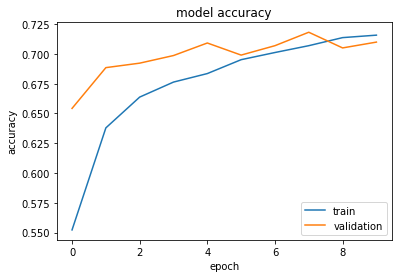

In [21]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

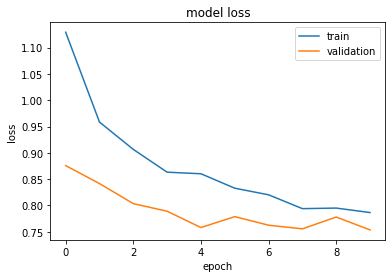

In [22]:
# summarize history for accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()